In [1]:
import cv2
import numpy as np

In [2]:
def is_solid_color_region(region, threshold=3.0):
    """region: (H, W, 3) の配列"""
    std = np.std(region.reshape(-1, 3), axis=0).mean()
    return std < threshold


def trim_padding_safely(img, scan_width=10, color_diff_th=10):
    h, w, _ = img.shape

    # 端から scan_width px の領域
    left_region = img[:, :scan_width]
    right_region = img[:, -scan_width:]
    top_region = img[:scan_width, :]
    bottom_region = img[-scan_width:, :]

    # パディングかどうか判定
    trim_left = is_solid_color_region(left_region)
    trim_right = is_solid_color_region(right_region)
    trim_top = is_solid_color_region(top_region)
    trim_bottom = is_solid_color_region(bottom_region)

    # 基準色（各端の平均）
    left_color = np.mean(left_region.reshape(-1, 3), axis=0)
    right_color = np.mean(right_region.reshape(-1, 3), axis=0)
    top_color = np.mean(top_region.reshape(-1, 3), axis=0)
    bottom_color = np.mean(bottom_region.reshape(-1, 3), axis=0)

    def color_diff(a, b):
        return np.linalg.norm(a - b)

    # 境界を探す
    left = 0
    if trim_left:
        for x in range(w):
            col = img[:, x, :]
            c = np.mean(col, axis=0)
            if color_diff(c, left_color) > color_diff_th:
                left = x
                break

    right = w - 1
    if trim_right:
        for x in range(w - 1, -1, -1):
            col = img[:, x, :]
            c = np.mean(col, axis=0)
            if color_diff(c, right_color) > color_diff_th:
                right = x
                break

    top = 0
    if trim_top:
        for y in range(h):
            row = img[y, :, :]
            c = np.mean(row, axis=0)
            if color_diff(c, top_color) > color_diff_th:
                top = y
                break

    bottom = h - 1
    if trim_bottom:
        for y in range(h - 1, -1, -1):
            row = img[y, :, :]
            c = np.mean(row, axis=0)
            if color_diff(c, bottom_color) > color_diff_th:
                bottom = y
                break

    # トリミング
    return img[top : bottom + 1, left : right + 1]

In [3]:
import math


def smart_resize(
    height: int,
    width: int,
    factor: int = 28,
    min_pixels: int = 56 * 56,
    max_pixels: int = 14 * 14 * 4 * 1280,
):
    """
    1. 高さ・幅がfactorの倍数
    2. ピクセル数が[min_pixels, max_pixels]内
    3. アスペクト比維持
    """
    if height < factor or width < factor:
        raise ValueError(
            f"height:{height} or width:{width} must be larger than factor:{factor}"
        )
    elif max(height, width) / min(height, width) > 200:
        raise ValueError(
            f"absolute aspect ratio must be smaller than 200, got {max(height, width) / min(height, width)}"
        )

    h_bar = round(height / factor) * factor
    w_bar = round(width / factor) * factor

    if h_bar * w_bar > max_pixels:
        beta = math.sqrt((height * width) / max_pixels)
        h_bar = math.floor(height / beta / factor) * factor
        w_bar = math.floor(width / beta / factor) * factor
    elif h_bar * w_bar < min_pixels:
        beta = math.sqrt(min_pixels / (height * width))
        h_bar = math.ceil(height * beta / factor) * factor
        w_bar = math.ceil(width * beta / factor) * factor

    return h_bar, w_bar


def convert_to_qwen25vl_format(
    bbox,
    orig_height,
    orig_width,
    factor=28,
    min_pixels=56 * 56,
    max_pixels=14 * 14 * 4 * 1280,
):
    new_height, new_width = smart_resize(
        orig_height, orig_width, factor, min_pixels, max_pixels
    )
    scale_w = new_width / orig_width
    scale_h = new_height / orig_height

    x1, y1, x2, y2 = bbox
    x1_new = round(x1 * scale_w)
    y1_new = round(y1 * scale_h)
    x2_new = round(x2 * scale_w)
    y2_new = round(y2 * scale_h)

    # 境界値チェック
    x1_new = max(0, min(x1_new, new_width - 1))
    y1_new = max(0, min(y1_new, new_height - 1))
    x2_new = max(0, min(x2_new, new_width - 1))
    y2_new = max(0, min(y2_new, new_height - 1))

    return [x1_new, y1_new, x2_new, y2_new]


def convert_from_qwen25vl_format(
    bbox_resized,
    orig_height,
    orig_width,
    factor=28,
    min_pixels=56 * 56,
    max_pixels=14 * 14 * 4 * 1280,
):
    """
    Qwen2.5-VL encoder のリサイズ後座標系の bbox を
    元画像座標系に戻す
    """

    # encoder 側で使われた最終解像度を再計算
    new_height, new_width = smart_resize(
        orig_height, orig_width, factor, min_pixels, max_pixels
    )

    scale_w = new_width / orig_width
    scale_h = new_height / orig_height

    x1_r, y1_r, x2_r, y2_r = bbox_resized

    # 逆スケーリング
    x1 = round(x1_r / scale_w)
    y1 = round(y1_r / scale_h)
    x2 = round(x2_r / scale_w)
    y2 = round(y2_r / scale_h)

    # 元画像サイズでクリップ
    x1 = max(0, min(x1, orig_width - 1))
    y1 = max(0, min(y1, orig_height - 1))
    x2 = max(0, min(x2, orig_width - 1))
    y2 = max(0, min(y2, orig_height - 1))

    return [x1, y1, x2, y2]

In [4]:
from PIL import ImageDraw, ImageFont
from data import prepare_dataset, prepare_repeated_dataset, prepare_clever_dataset


def get_image_with_bbox(image, bboxes):
    W, H = image.size
    draw = ImageDraw.Draw(image)
    for idx, b in enumerate(bboxes):
        x1, y1, x2, y2 = convert_from_qwen25vl_format(b["bbox_2d"], H, W)

        # 描画
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

    return draw._image

/mnt/taurine511/AI_exercise/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import re
import json


def extract_prediction(response):
    format_pattern = re.compile(
        r"^\s*"
        r"<think>\s*(.+?)\s*</think>\s*"  # group 1: think block
        r"<answer>\s*(.+?)\s*</answer>\s*"  # group 2: answer block
        r"$",
        re.DOTALL,
    )

    match = format_pattern.match(response)

    if not match:
        return []

    think_block = match.group(1).strip()
    answer_block = match.group(2).strip()

    # think と answer の両方が空ならNG
    if not think_block or not answer_block:
        return []

    # answer を JSON としてロード
    try:
        return json.loads(answer_block)
    except json.JSONDecodeError:
        return []

In [6]:
with open("outputs/vllm_generations_20251218_052420.json", "r") as f:
    generations = json.load(f)

dataset = prepare_dataset()

In [7]:
def show_generation(generation):
    prompt_id = generation["prompt_id"]
    text = generation["text"]
    predict = extract_prediction(text)

    example = dataset[prompt_id]
    image = example["images"][1]
    image_with_bbox = get_image_with_bbox(image, predict)
    return image_with_bbox


def show_batch_generation(generations):
    prompt_id = generations[0]["prompt_id"]
    predict = []
    for generation in generations:
        text = generation["text"]
        predict += extract_prediction(text)

    example = dataset[prompt_id]
    image = example["images"][1]
    image_with_bbox = get_image_with_bbox(image, predict)
    return image_with_bbox

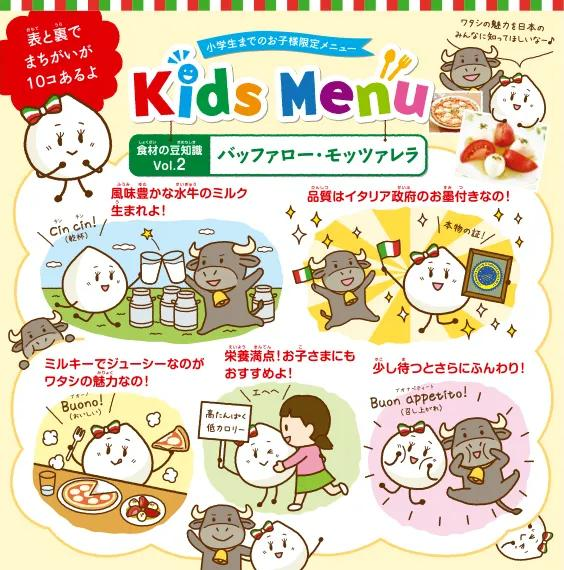

In [8]:
task = 0
n = 0
show_generation(generations["generations"][task * 100 + n])

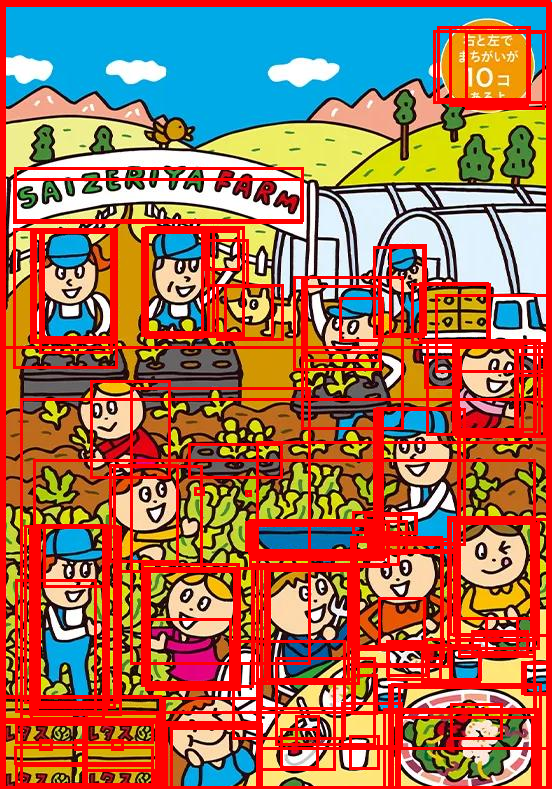

In [9]:
n = 30
show_batch_generation(generations["generations"][n * 100 : (n + 1) * 100])

In [10]:
bboxes = sum(
    [
        extract_prediction(gen["text"])
        for gen in generations["generations"][n * 100 : (n + 1) * 100]
    ],
    [],
)
X1, Y1, X2, Y2 = zip(*[bbox["bbox_2d"] for bbox in bboxes])
x1, y1, x2, y2 = min(X1), min(Y1), max(X2), max(Y2)
x2, y2

(560, 812)

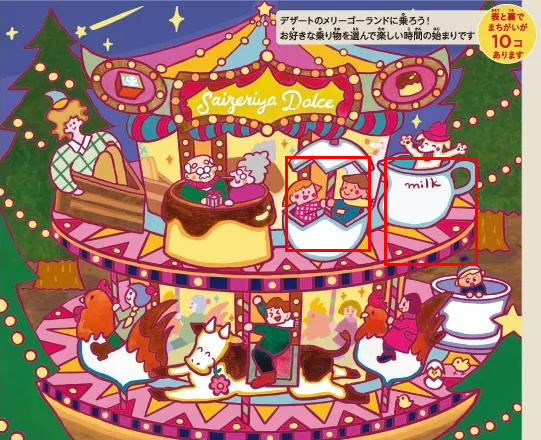

In [31]:
n = 21
example = dataset[n]

result = [         
    {"bbox_2d":
[378, 160,
469, 270],
"label":  
"cake"},  
    {"bbox_2d":
[280, 159,
364, 256],
"label":  
"cup"}    
]   

get_image_with_bbox(example["images"][1], result)

      

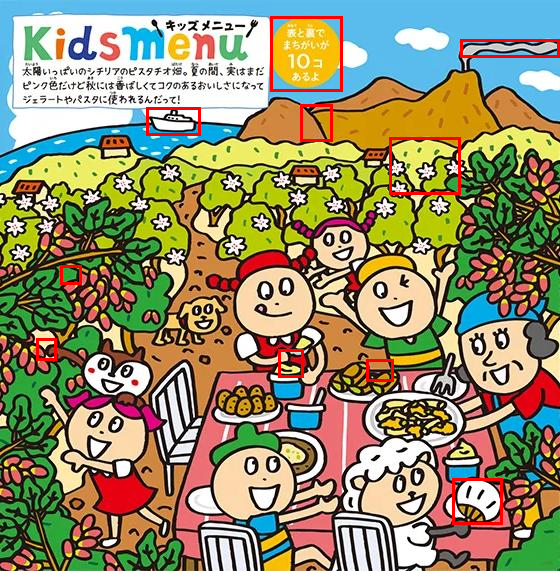

In [12]:
n = 5
example = dataset[n]
get_image_with_bbox(example["images"][0], example["left_labels"])

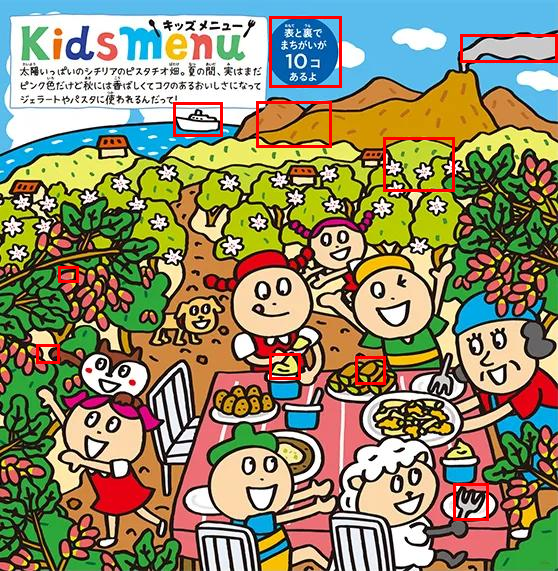

In [13]:
n = 5
example = dataset[n]
get_image_with_bbox(example["images"][1], example["right_labels"])